# Examining coverage of records by sourmash hashes for DNA and AA k-mers

In [1]:
ls data

GCF_001650295.1_ASM165029v1_genomic.fna
cds_from_genomic.fna
protein.faa


In [2]:
import sourmash
from sourmash.minhash import _get_max_hash_for_scaled
import screed
from collections import defaultdict
from matplotlib import pylab
import numpy as np

In [3]:
sources = { "CDS": "data/cds_from_genomic.fna", # DNA / coding sequences
            "prot": "data/protein.faa" } # protein sequences

In [4]:
def sketch_by_record(filename, minhash):
    rev_d = defaultdict(set)
    record_names = defaultdict(int)
    with screed.open(filename) as records:
        for record in records:
            record_names[record.name] = len(record.sequence)
            mh = minhash.copy_and_clear()
            if minhash.moltype == 'DNA':
                mh.add_sequence(record.sequence, force=True)
            elif minhash.moltype == 'protein':
                mh.add_protein(record.sequence)
            else:
                assert 0
            for hashval in mh.hashes:
                rev_d[hashval].add(record.name)
    return record_names, rev_d



In [5]:
class HashCoverageOfRecords:
    def __init__(self, ksize, min_scaled, moltype, filename):
        self.ksize = int(ksize)
        self.min_scaled = int(min_scaled)
        assert moltype in ('DNA', 'protein')
        self.moltype = moltype
        self.filename = filename

        is_protein=None
        if moltype == 'protein':
            is_protein = True
        elif moltype == 'DNA':
            is_protein = False

        self.base_minhash = sourmash.MinHash(n=0, ksize=ksize, scaled=min_scaled, is_protein=is_protein)
        self.load()

    def load(self):
        names, rev_d = sketch_by_record(self.filename, self.base_minhash)
        self.names_to_size = names
        self.hashes_to_records_d = rev_d

    def calc_missing(self, scaled):
        names = self.names_to_size
        rev_d = self.hashes_to_records_d

        scaled = int(scaled)

        hit = set()
        names_set = set(names)
        for hashval, v in rev_d.items():
            max_hash = _get_max_hash_for_scaled(scaled)
            if hashval < max_hash:
                hit.update(v)
    
        assert not hit - names_set

        # link missing names to size in original dict
        missing_d = dict( ((k, names[k]) for k in names_set - hit) )

        # return size of intersection, dict of missing names -> sizes
        return hit.intersection(names_set), missing_d

    def print_missing_stats(self, scaled):
        scaled = int(scaled)
        found, missing = self.calc_missing(scaled=scaled)

        total = len(found) + len(missing)
        assert total == len(self.names_to_size), (len(self.names_to_size), len(found), len(missing))
    
        p_found = f"{len(found) / total * 100:.1f}%"
        p_missing = f"{len(missing) / total * 100:.1f}%"
    
        if scaled is not None:
            print(f"Found {len(found)} ({p_found}) / missed {len(missing)} ({p_missing}) @ scaled={scaled}")
        else:
            print(f"Found {len(found)} ({p_found}) / missed {len(missing)} ({p_missing})")

    def calc_missing_stats(self, scaled_list):
        x_missing = []
        x_missing_f = []
        
        for scaled in scaled_list:
            _, missing = self.calc_missing(scaled=scaled)
            x_missing.append(len(missing))
            x_missing_f.append(len(missing) / len(self.names_to_size))        

        return np.array(x_missing), np.array(x_missing_f)

In [6]:
dna_ksize = 21
dna_cov = HashCoverageOfRecords(dna_ksize, 10, 'DNA', sources["CDS"])
dna_cov.print_missing_stats(scaled=10)

Found 5743 (100.0%) / missed 2 (0.0%) @ scaled=10


In [7]:
dna_cov.print_missing_stats(scaled=100)
dna_cov.print_missing_stats(scaled=1000)

Found 5526 (96.2%) / missed 219 (3.8%) @ scaled=100
Found 2899 (50.5%) / missed 2846 (49.5%) @ scaled=1000


In [8]:
dna_cov.print_missing_stats(scaled=100)
_, missing = dna_cov.calc_missing(scaled=10)
print('sizes of missed records:', list(missing.values()))

Found 5526 (96.2%) / missed 219 (3.8%) @ scaled=100
sizes of missed records: [48, 60]


In [9]:
prot_ksize = 7
prot_cov = HashCoverageOfRecords(prot_ksize, 10, 'protein', sources["prot"])
prot_cov.print_missing_stats(scaled=10)

Found 5011 (99.6%) / missed 20 (0.4%) @ scaled=10


In [10]:
prot_cov.print_missing_stats(scaled=10)
prot_cov.print_missing_stats(scaled=100)
prot_cov.print_missing_stats(scaled=1000)

Found 5011 (99.6%) / missed 20 (0.4%) @ scaled=10
Found 4204 (83.6%) / missed 827 (16.4%) @ scaled=100
Found 1226 (24.4%) / missed 3805 (75.6%) @ scaled=1000


In [11]:
scaled_vals = [10, 20, 50, 100, 200, 500, 1000]

dna_missing, dna_missing_f = dna_cov.calc_missing_stats(scaled_vals)
prot_missing, prot_missing_f = prot_cov.calc_missing_stats(scaled_vals)



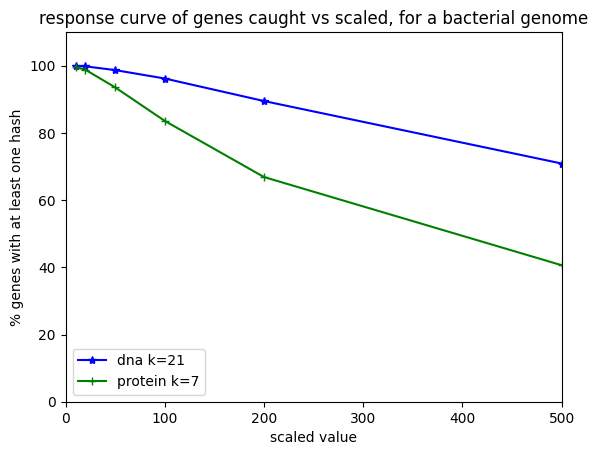

In [12]:
dna_found_p = (1 - np.array(dna_missing_f)) * 100
prot_found_p = (1 - np.array(prot_missing_f)) * 100

pylab.plot(scaled_vals, dna_found_p, 'b*-', label=f'dna k={dna_cov.ksize}')
pylab.plot(scaled_vals, prot_found_p, 'g+-', label=f'protein k={prot_cov.ksize}')
pylab.ylim(0, 110)
pylab.xlim(0, 500)
pylab.xlabel('scaled value')
pylab.ylabel('% genes with at least one hash')
pylab.title('response curve of genes caught vs scaled, for a bacterial genome')
pylab.legend(loc='lower left')